# **Advanced Machine Learning - **<br/>
**Master's Degree in Data Science (A.Y. 2021/2022)**<br/>
**University of Milano - Bicocca**<br/>

Assignment 03

Silvia Ranieri 878067


La relazione deve contenere:
- una descrizione dell'architettura progettata
- i parametri contano per ogni strato
- gli iperparametri utilizzati per l'addestramento (dimensione batch, tasso di apprendimento, ottimizzatore, numero di epoche, ecc.)
- un grafico della perdita/accuratezza della formazione e della convalida
- prestazioni di classificazione su formazione, convalida (se utilizzata) e set di test


#LIBRERIE

In [ ]:
import numpy as np 
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf

#Preparazione dei dati

**Obiettivo**: La CNN deve essere progettata con l'obiettivo di raggiungere la massima precisione possibile sul set di prova, con il vincolo rigido di un massimo di 6K parametri apprendibili.

Set di dati: Set di dati di input: cifre MNIST (dimensioni di input 28x28x1, numero di classi: 10).

Questo dataset è composto da un set di addestramento di 60.000 esempi e un set di test di 10.000.

 Le cifre Mnist vanno da 0 a 9, quindi questo è un problema di classificazione multiclasse con 10 classi e l'immagine di input è (28 x 28).

In primo luogo, si normalizza nella scala di grigi per ridurre l'effetto delle differenze di illuminazione al fine di facilitare il training. Dopo si passa a espandere la dimensione dei dati 28x28x1 per gestire l'input della CNN. 

Vengono convertiti i dati di train e test in una matrice di classe binaria con dieci caratteristiche.


8


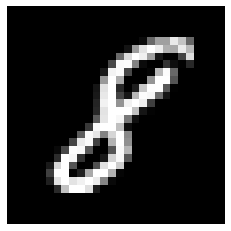

In [ ]:
# Model/data parameters 
num_classes = 10 #digits 0-9
input_shape = (28,28,1)

# load the data and divide it into train/test split
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train= x_train.astype("float32") / 255
x_test, x_test.astype("float32") / 255

# plot some samples
image_index  = 7777
print(y_train[image_index])
plt.imshow(x_train[image_index],cmap='gray')
plt.axis("off")
plt.show()

In [ ]:
x_train.shape

(60000, 28, 28)

In [ ]:
#expand dimension of our data (28,28,1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape: ", x_train.shape)
print("x_train samples: ", x_train.shape[0])
print("x_test sample: ", x_test.shape[0])   

x_train shape:  (60000, 28, 28, 1)
x_train samples:  60000
x_test sample:  10000


In [ ]:
#convert class vectors to binary class matrics
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_train.shape

(60000, 10)

Definisco le metriche che mi serviranno per valutare il modello e le sue performance:

In [ ]:
#definizione delle metriche:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#MODELLO

Per soddisfare il vincolo e mantenere il numero di parametri sotto 6k, il modello ha 2 livelli di convoluzione con dimensione 8 per ogni livello, mentre la dimensione del filtro è (3x3x1). Dopo un livello di pooling massimo di 2x2. Poi uno strato convoluzione di 16 con dimensione del filtro è (3x3) e livello di polling 2x2. Il totale dei parametri è 5842.
Attraverso la regolarizzazione (Dropout) viene eliminato il 30% dei neuroni. 

**Funzione di attivazione:** scelgo la funzione ReLU che è adatta per questo modello e in generale è una buona scelta per i livelli nascosti.



In [ ]:
model = keras.Sequential (
    [
      keras.Input(shape =  input_shape),
    
      layers.Conv2D(8, kernel_size=(3,3), activation='relu'),
      layers.Conv2D(8, kernel_size=(3,3), activation='relu'),
      layers.MaxPool2D(pool_size=(2,2)),
     
      layers.Conv2D(16, kernel_size=(3,3), activation='relu'),
      layers.MaxPool2D(pool_size=(2,2)),
      
      layers.Flatten(),
      layers.Dropout(0.3),
      layers.Dense(num_classes, activation='softmax'),
    ]
)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 8)         80        
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 8)         584       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 8)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 10, 10, 16)        1168      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 400)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 400)              

#Addestramento

**Funzione di perdita:** scelgo categorical_crossentropy perché è particolarmente adatto per compiti di classificazione categoriale, ho provato mse, mae e sparse cross_entropy categorico ma con risultati peggiori.

**Ottimizzatore:** Ho scelto Adam ho provato a utilizzare un ottimizzatore diverso come SGD ma Adam funziona meglio.

**Epoche:** il numero di epoche è 90, ho notato che aumentando il modello non migliora.

**Dimensione batch:** Ho provato diversi valori e notato che con 128 si otteneva risultati migliori.

**Metriche:** Ho stabilito diverse metriche l’accuratezza, f1_m, precision, recall.

Ho impostato i dati di validazione al 20% del training. 

**Funzione di output: **softmax, prestazioni migliori per questo modello. Inoltre, utile nei problemi di classificazione con n classi (n > 2)


In [ ]:
batch_size = 128
epochs = 90  

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',f1_m,precision_m, recall_m])

network_history = model.fit(x_train, y_train, batch_size=batch_size,  epochs = epochs, validation_split=0.2)

Epoch 1/90
375/375 [==============================] - 8s 21ms/step - loss: 0.5783 - accuracy: 0.8157 - f1_m: 0.7693 - precision_m: 0.8282 - recall_m: 0.7391 - val_loss: 0.1262 - val_accuracy: 0.9645 - val_f1_m: 0.9643 - val_precision_m: 0.9720 - val_recall_m: 0.9568
Epoch 2/90
375/375 [==============================] - 8s 21ms/step - loss: 0.1543 - accuracy: 0.9530 - f1_m: 0.9533 - precision_m: 0.9614 - recall_m: 0.9454 - val_loss: 0.0850 - val_accuracy: 0.9747 - val_f1_m: 0.9758 - val_precision_m: 0.9801 - val_recall_m: 0.9715
Epoch 3/90
375/375 [==============================] - 8s 23ms/step - loss: 0.1157 - accuracy: 0.9636 - f1_m: 0.9645 - precision_m: 0.9698 - recall_m: 0.9594 - val_loss: 0.0704 - val_accuracy: 0.9794 - val_f1_m: 0.9796 - val_precision_m: 0.9830 - val_recall_m: 0.9762
Epoch 4/90
375/375 [==============================] - 10s 26ms/step - loss: 0.0978 - accuracy: 0.9695 - f1_m: 0.9695 - precision_m: 0.9737 - recall_m: 0.9654 - val_loss: 0.0605 - val_accuracy: 0.9822

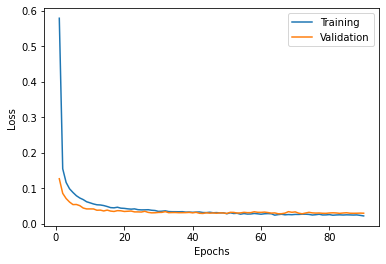

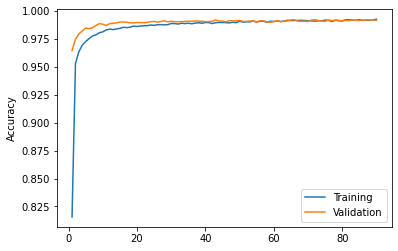

In [ ]:
x_plot = list(range(1,len(network_history.history['val_accuracy']) + 1))


def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    # plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['accuracy'])
    plt.plot(x_plot, network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

plot_history(network_history)

Dal grafico si evidenzia: la perdita diminuisce e la precisione molto simile tra training e validation, non si verifica overfitting.


**VALUTAZIONE** **SUL TRAINING**



Performance sul training

Abbiamo un’accuratezza alta del 0,99%., anche le metriche hanno valori alti questo significa che è un buon modello.

Inoltre sotto ho  riportato il rapporto di classificazione sul traing set.

Come si vede la precisione sul training set in alcune categorie è 1; quindi, i falsi positivi sono molto bassi e i veri positivi sono molto alti.


In [ ]:
score = model.evaluate(x_train, y_train, verbose=0)
print ('Train loss', score[0])
print('Train accuracy', score[1])

Train loss 0.011670236475765705
Train accuracy 0.9965999722480774


In [ ]:
print("\n%s: %.2f%%" % ( model.metrics_names[1], score[1]*100))
print("\n%s: %.2f%%" % ( model.metrics_names[2], score[2]*100))
print("\n%s: %.2f%%" % ( model.metrics_names[3], score[3]*100))
print("\n%s: %.2f%%" % ( model.metrics_names[4], score[4]*100))
print("\n%s: %.2f" % ( model.metrics_names[0], score[0]))


accuracy: 99.66%

f1_m: 99.66%

precision_m: 99.69%

recall_m: 99.64%

loss: 0.01


In [ ]:
predicted = np.round(model.predict(x_train))
from sklearn.metrics import classification_report
targets = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
print(classification_report(y_train,predicted,  target_names=targets))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5923
           1       1.00      1.00      1.00      6742
           2       0.99      1.00      1.00      5958
           3       1.00      1.00      1.00      6131
           4       1.00      1.00      1.00      5842
           5       1.00      1.00      1.00      5421
           6       1.00      1.00      1.00      5918
           7       0.99      1.00      1.00      6265
           8       1.00      1.00      1.00      5851
           9       1.00      0.99      0.99      5949

   micro avg       1.00      1.00      1.00     60000
   macro avg       1.00      1.00      1.00     60000
weighted avg       1.00      1.00      1.00     60000
 samples avg       1.00      1.00      1.00     60000



**VALUTAZIONE SUL TEST SET**

Questa valutazione è necessaria per capire se dopo l'addestramento il modello è in grado di generalizzare bene con dati non visti. Si ottengono valori alti accuratezza del 0.98% ottime prestazioni e la perdita è bassa. Inoltre sotto ho  riportato il rapporto di classificazione sul testset.
La precisione minore è sul numero 8 il motivo può essere che addestratore confonde con il numero 9. In generale valori molto alti, questo indica che 
sul set di test ci sono falsi positivi molto bassi e veri positivi molto alti.
Quindi possiamo concludere che è un buon modello.


In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print ('Test loss', score[0])
print('Test accuracy', score[1])

Test loss 7.347593784332275
Test accuracy 0.9889000058174133


In [ ]:
print("\n%s: %.2f%%" % ( model.metrics_names[1], score[1]*100))
print("\n%s: %.2f%%" % ( model.metrics_names[2], score[2]*100))
print("\n%s: %.2f%%" % ( model.metrics_names[3], score[3]*100))
print("\n%s: %.2f%%" % ( model.metrics_names[4], score[4]*100))
print("\n%s: %.2f" % ( model.metrics_names[0], score[0]))


accuracy: 98.89%

f1_m: 98.89%

precision_m: 98.89%

recall_m: 98.89%

loss: 7.35


In [ ]:
predicted = np.round(model.predict(x_test))
from sklearn.metrics import classification_report
targets = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
print(classification_report(y_test,predicted,  target_names=targets))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       980
           1       1.00      0.97      0.99      1135
           2       0.98      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       1.00      0.98      0.99      1028
           8       0.96      1.00      0.98       974
           9       0.99      0.99      0.99      1009

   micro avg       0.99      0.99      0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000
 samples avg       0.99      0.99      0.99     10000

